# Text Generation, Style Transfer

## Text Generation

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path, 'r',-1, 'utf-8').read().lower()
print('corpus length:', len(text))

600901/600901 [==============================] - 1s 1us/step
corpus length: 600893


In [2]:
# Length of extracted character sequences
maxlen = 60
# We sample a new sequence every `step` characters
step = 3
# This holds our extracted sequences
sentences = []
# This holds the targets (the follow-up characters)
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))
# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)
# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [3]:
from keras import layers
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [4]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [5]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [6]:
import random
import sys
for epoch in range(1, 10):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    model.fit(x, y,
              batch_size=128,
              epochs=1)
    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text + '"')
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)
        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            generated_text += next_char
            generated_text = generated_text[1:]
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1565/1565 [==============================] - 284s 180ms/step - loss: 1.9671
--- Generating with seed: "amps, and pretend to be stars--the people
then call them ide"
------ temperature: 0.2
amps, and pretend to be stars--the people
then call them ideally and in the stronger and from the stronger and to the something only the stronger and in the something in the stronger and in the stronger and the stronger and which the something is a more and present of the stronger of the from the stronger and stronger of the something in the desponsible of the stronger and stronger of the stronger of the stronger or the stronger of the something as a still
------ temperature: 0.5
 of the stronger or the stronger of the something as a still man to he oreally and the more and more a stronger was the stronger and for the distrument estence and for the dust is a merild as former to de and all the freerly and the stronger of the from the sectrative in spilition of the stronger of the something as 

## Style transfer

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
content_path= '/content/drive/MyDrive/Dataset/style_transfer/cat.jpg'
style_path='/content/drive/MyDrive/Dataset/style_transfer/starry_night.jpg'

Mounted at /content/drive


In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

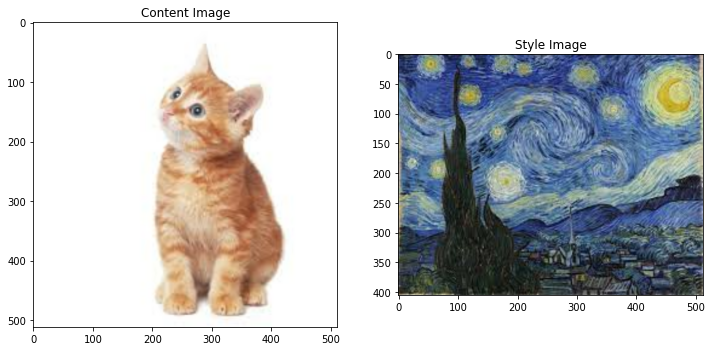

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image') # 이 이미지에

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image') # 이 스타일을 입혀보자!

Build a pretrained VGG model with Imagenet

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
r = vgg(x)

574710816/574710816 [==============================] - 10s 0us/step


In [ ]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

print(imagenet_labels[np.argsort(r)[0,::-1][:5]+1])

10484/10484 [==============================] - 0s 0us/step
['tabby' 'Egyptian cat' 'tiger cat' 'Norwich terrier' 'piggy bank']


In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  # Creates a vgg model that returns a list of intermediate output values.
  # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
  
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 406, 512, 64)
  min:  0.0
  max:  707.1314
  mean:  21.92893

block2_conv1
  shape:  (1, 203, 256, 128)
  min:  0.0
  max:  2439.1912
  mean:  129.38834

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7562.7827
  mean:  122.63791

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  16078.676
  mean:  490.2341

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3324.067
  mean:  41.042652



In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  168992.12
    mean:  413.55838

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  279494.5
    mean:  10322.939

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  381146.75
    mean:  7336.9937

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4177247.2
    mean:  103381.09

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  47497.023
    mean:  606.8485

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  1156.6023
    mean:  7.315929


Training 

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                        for name in style_outputs.keys()])
    
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                        for name in content_outputs.keys()])
    
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 1e-2
content_weight = 1e4

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

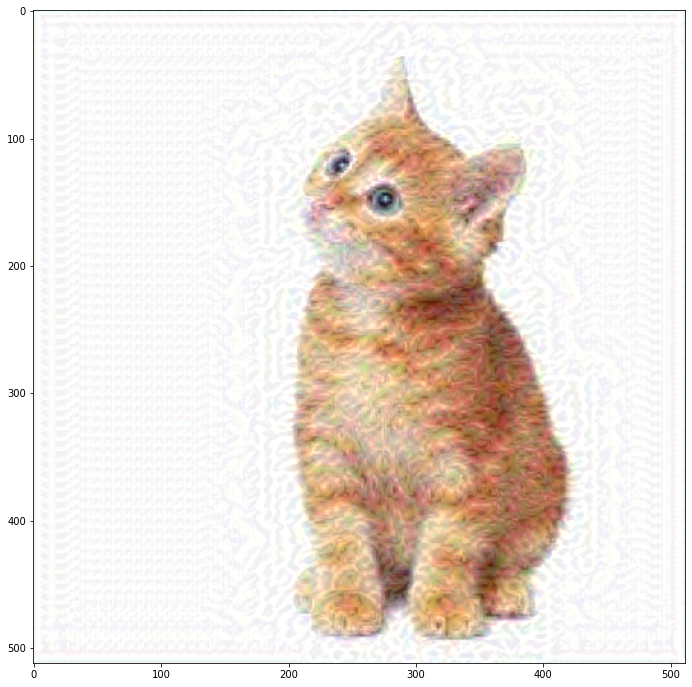

In [ ]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

Training (Additional)

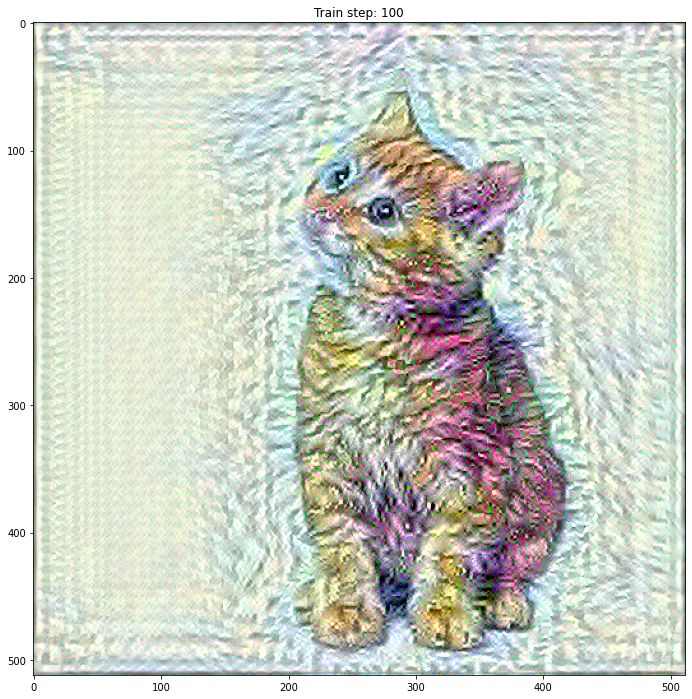

In [ ]:
epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    display.clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()
